---
# **Análise do comportamento de compra do cliente na Black Friday**

---
## **Sumário**
#### **1. Introdução**
#### **2. Pré-Processamento**
> ##### 2.1 Importação de bibliotecas
> ##### 2.2 Importação do dataset
#### **3. Análises de Faixa Etária**
> ##### 3.1 Total de compras por faixa etária
> ##### 3.2 Compra média por faixa etária e cidade
#### **4. Análise de categoria de produto**
> ##### 4.1 Número de compras de cada categoria de produto por cidade
> ##### 4.2 Média de compra da categoria 1 do produto por cidade
> ##### 4.3 Média de compra da categoria 2 do produto por cidade
> ##### 4.4 Média de compra da categoria 3 do produto por cidade
#### **5. Análise de gênero**
> ##### 5.1 Número de compras e média de compras por gênero
> ##### 5.2 Média de compras por gênero e faixa etária
> ##### 5.3 Média de compras por gênero e cidade
#### **6. Análise de emprego**
> ##### 6.1 Média de compras por emprego
> ##### 6.2 Emprego por cidade
#### **7. Análise de estado civil**
#### **8. HeatMap**
#### **9. ClusterMap**


---
#### **1. Introdução**

Neste projeto, exploraremos algumas perguntas que podem ser realizadas sobre os dados e como extrair essas respostas o mais rápido possível. Para fazer isso, será escrito diversas funções para facilitar o processo, além da visualização por meio de gráficos.

---
#### **2. Pré-processamento**

##### **2.1 Importação de bibliotecas**


In [265]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('ticks')
plt.style.use('ggplot')

In [266]:
data =  pd.DataFrame({
'Variables': ['User_ID','Product_ID','Gender','Age','Occupation','City_Category','Stay_In_Current_City_Years','Marital_Status',
           'Product_Category_1', 'Product_Category_2','Product_Category_3','Purchase'],
'Definition' : ['User ID','Product ID','Sex of User','Age in bins',"Occupation (Masked)","Category of the City (A,B,C)"
               ,'Number of years stay in current city','Marital Status',"Product Category (Masked)","Product may belongs to other category also (Masked)",
            "Product may belongs to other category also (Masked)","Purchase Amount  (Target Variable)"]} )
data.set_index('Variables')

,Definition
Variables,
User_ID,User ID
Product_ID,Product ID
Gender,Sex of User
Age,Age in bins
Occupation,Occupation (Masked)
City_Category,"Category of the City (A,B,C)"
Stay_In_Current_City_Years,Number of years stay in current city
Marital_Status,Marital Status
Product_Category_1,Product Category (Masked)


---

In [267]:
pd.set_option('display.max_columns', 12)

##### **2.2 Importação do dataset**


Usaremos o conjunto de dados da Black Friday, que pode ser encontrado no Kaggle:
https://www.kaggle.com/sdolezel/black-friday

In [268]:
df = pd.read_csv('train.csv')
df.head(3)

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422


In [269]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  object 
 7   Marital_Status              550068 non-null  int64  
 8   Product_Category_1          550068 non-null  int64  
 9   Product_Category_2          376430 non-null  float64
 10  Product_Category_3          166821 non-null  float64
 11  Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


In [270]:
df.isnull().sum()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            173638
Product_Category_3            383247
Purchase                           0
dtype: int64

Embora nossa primeira impressão dos dados seja de que eles parecem organizados, ainda faltam alguns valores. As colunas Product_Category (2 e 3) têm toneladas de variáveis ​​NaNs em vez de representação numérica. A informação que podemos obter disso é que cada NaN representa o fato de que o produto desta linha dada não pertence àquela categoria específica. 

Por exemplo, o produto da primeira linha (Product_id = P00069042) é identificado como produto 3 e pertence apenas à categoria número 1. Por outro lado, o produto da segunda linha é identificado como 1 na categoria 1, como 6 na segunda categoria e 14 na terceira categoria de produto, o que significa que pertence a todas as categorias.

Além disso, devemos estar cientes do fato de que `groupby` e `pivot_table` ignoram NaNs automaticamente. Isso torna nosso trabalho significativamente mais fácil, pois usaremos essas duas técnicas para agrupar alguns dados e computar operações sobre eles. Além disso, também é importante mencionar que embora nossos dados possam ter alguns outliers, consideraremos que já estão explorados em relação a esse assunto.

---
#### **3. Análises por faixa etária**

##### **3.1 Total de compras por faixa etária**

Iniciaremos este projeto identificando o total de compras por faixa etária e as médias de compra por faixa etária e cidade. Para fazer isso, temos que, primeiro, usar o método `value_counts()` para contar o número de compras de cada grupo e traçar um chat de barra simples e, segundo, criar uma tabela dinâmica em que os índices são os as colunas Age e City_Category e então traçar um gráfico de barras.


O gráfico a seguir mostra que as pessoas entre 26 e 35 anos ocupam o primeiro lugar em quantidade de compras, seguidas das faixas etárias de 36 a 45 anos e de 18 a 25 anos que possuem cerca de metade das compras em relação ao primeiro grupo.

In [271]:
color_1 = ['lightslategray', 'mediumvioletred', 'sandybrown', 'sienna' , 'navy', 'olive', 'darkgreen']

Text(0, 0.5, 'Número de Compras')

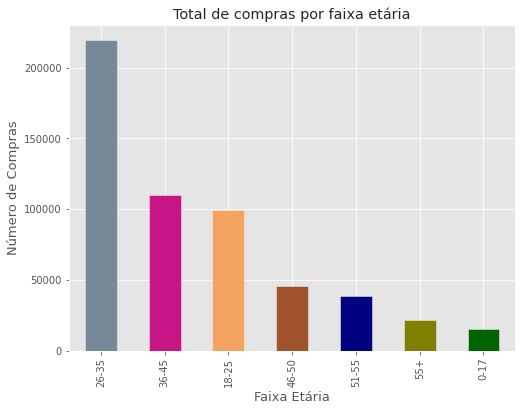

In [272]:
df.Age.value_counts().plot(kind = 'bar', color = color_1, title = 'Total de compras por faixa etária', figsize =(8,6))
plt.xlabel('Faixa Etária', fontsize = 13)
plt.ylabel('Número de Compras', fontsize = 13)


---
##### **3.2 Compra média por faixa etária e cidade**

In [273]:
age_group_city = df.loc[:,['Age', 'City_Category', 'Purchase']] 

age_group_city = age_group_city.pivot_table(age_group_city, index = ['Age', 'City_Category'], aggfunc = 'mean')

Text(0.5, 0, 'Média de compras')

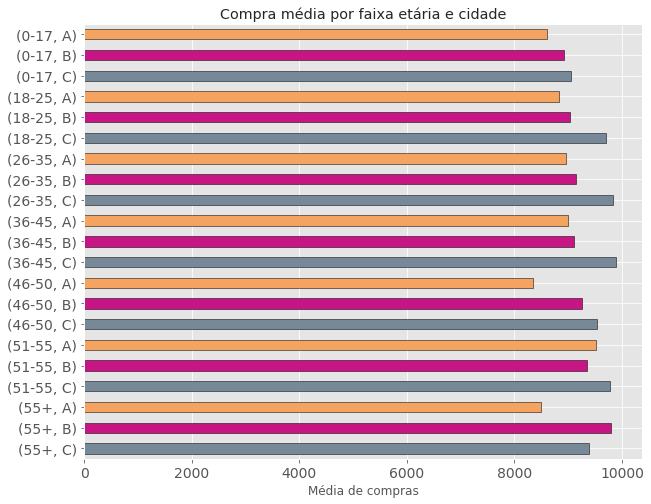

In [274]:
color = ('lightslategray','mediumvioletred','sandybrown')

age_group_city.sort_index(ascending=False).plot(
    kind='barh',
    figsize=(10, 8),
    cmap='viridis',
    edgecolor='black',
    fontsize=14,
    legend = False,
    title='Compra média por faixa etária e cidade',
    color = color
    ).yaxis.label.set_visible(False)
plt.ylabel('Faixa etária, Cidade')
plt.xlabel('Média de compras')


Mesmo que o gráfico acima nos forneça as informações que desejamos, é um pouco confuso. Devemos ter em mente que quanto mais fácil de entender o enredo, mais 'feliz' ficará quem o está lendo. Como Cientistas de Dados ou Analistas de Dados, temos a obrigação de transmitir a mensagem da forma mais clara possível, para que aqueles que olharem para o gráfico ou painel entendam tudo imediatamente. Portanto, para fazer uma comparação clara entre esses grupos, representaremos cada um deles separadamente.

In [275]:
def trim_axs(axs, N):
    axs = axs.flatten()
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

In [276]:
def individual_bar_plots(dataframe, item, title, ax = None):
    

    obj = dataframe.loc[item,:]

    obj.plot( kind = 'barh',
            color = color,
            edgecolor = 'black', 
            ax = ax,   
            legend = None,              
            ).set_title(f'{title} {item}')
    
    ax.set_xlabel('Média de compras')

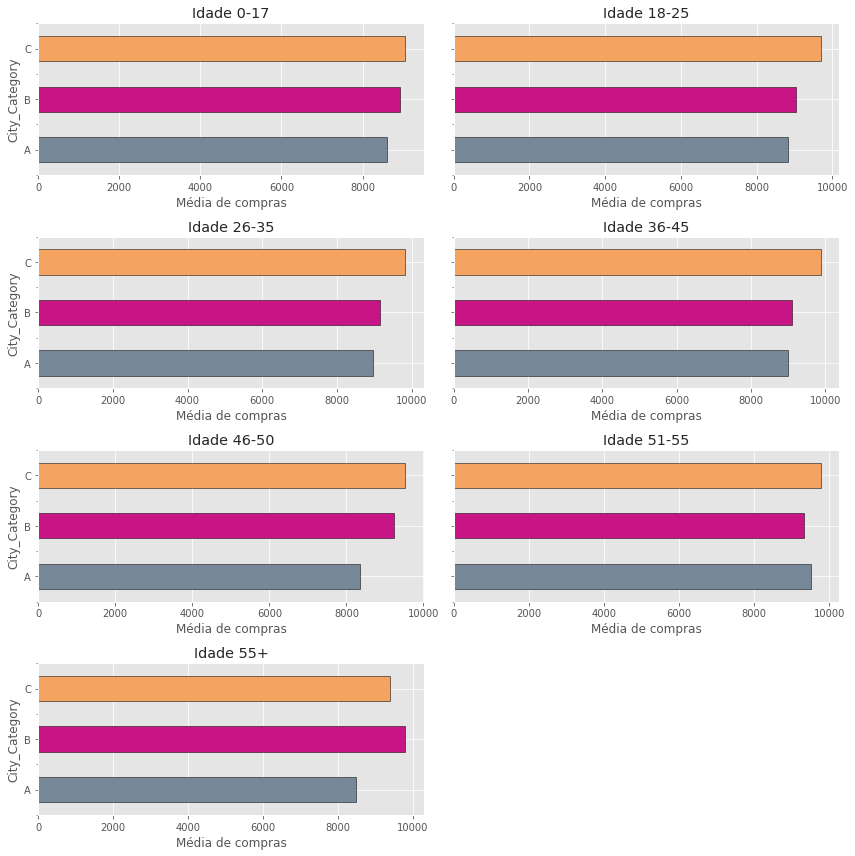

In [277]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(12, 12), sharey=True)

ax = trim_axs(ax, len(df.Age.unique()))

age_list = ['0-17','18-25','26-35','36-45', '46-50','51-55','55+']

for subplot, Age in zip(ax.flatten(), age_list):
    individual_bar_plots(age_group_city, Age, ax=subplot, title = 'Idade')
    
plt.tight_layout()

Agora podemos ver claramente que, por exemplo, dos 0 aos 55 anos, a compra média da cidade C é maior do que as outras. Também podemos ver que a cidade B ocupa o primeiro lugar apenas no grupo de 55 anos ou mais. Em suma, podemos obter muitas informações desses lotes, e aqueles que precisam deles para tomar decisões de negócios provavelmente ficarão satisfeitos.

---

#### **4. Análise de categoria de produto**

A segunda tarefa é analisar as categorias e os produtos. Começaremos traçando um gráfico de barras com o total de compras de cada categoria em cada cidade. Em seguida, usaremos a função que construímos para traçar gráficos individuais de todos os produtos para cada categoria. É importante mencionar que um produto pode pertencer a diferentes categorias e grupos. Por exemplo, o produto **P00248942** pertence a todas as categorias, mas é denominado como grupo 1 na primeira categoria, grupo 6 na segunda e 14 na terceira. Com isso dito, vamos começar nossa análise.

In [278]:
df.head(2 )

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200


##### **4.1 Número de compras de cada categoria de produto por cidade**

O gráfico abaixo mostra que temos uma espécie de padrão em termos de quantidade de compras. Como podemos ver, a categoria de produto 1 ocupa o primeiro lugar, seguida pela categoria de produto 2 e categoria de produto 3 em todas as cidades. O que difere cada cidade quanto ao número de compras é o fato de os consumidores da cidade B comprarem mais produtos de todas as categorias do que as cidades A e C.

Text(0.5, 1.0, 'Total de compras de cada categoria de produto por cidade')

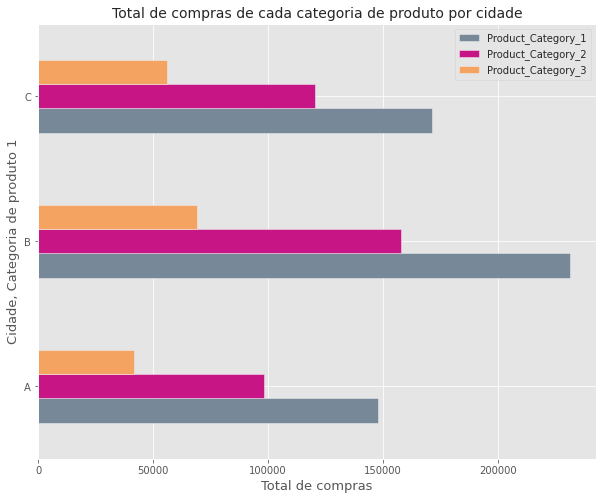

In [279]:
Purchase_by_City_df = df.loc[:,[ 'City_Category','Product_Category_1', 'Product_Category_2','Product_Category_3']] 

Purchase_by_City_Pivt = Purchase_by_City_df.pivot_table(Purchase_by_City_df, index = ['City_Category'], aggfunc = 'count')

Purchase_by_City_Pivt.plot( kind = 'barh',figsize =(10,8), color = color)

plt.xlabel('Total de compras', fontsize = 13)
plt.ylabel('Cidade, Categoria de produto 1', fontsize = 13)
plt.title('Total de compras de cada categoria de produto por cidade', fontsize = 14 )


In [280]:
Purchase_by_City_Pivt

,Product_Category_1,Product_Category_2,Product_Category_3
City_Category,,,
A,147720,98361,41519
B,231173,157683,69243
C,171175,120386,56059


##### **4.2 Média de compra da categoria 1 do produto por cidade**

In [281]:
df_city_A = df.loc[df.City_Category == 'A', :]
df_city_B = df.loc[df.City_Category == 'B', :]
df_city_C = df.loc[df.City_Category == 'C', :]
df_city_A.head(3)

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422


In [282]:
City_A_Category_1 = df_city_A.groupby('Product_Category_1').mean()['Purchase']
City_B_Category_1 = df_city_B.groupby('Product_Category_1').mean()['Purchase']
City_C_Category_1 = df_city_C.groupby('Product_Category_1').mean()['Purchase']

In [283]:
type(City_C_Category_1)

pandas.core.series.Series

In [284]:
prod1_df = pd.concat([City_A_Category_1,City_B_Category_1, City_C_Category_1], axis = 1)
prod1_df.columns = ['City_A', 'City_B', 'City_C']

In [285]:
prod1_df

,City_A,City_B,City_C
Product_Category_1,,,
1,13047.176933,13435.925703,14233.967350
2,10903.554796,11133.902528,11715.205111
3,10032.381145,9998.072552,10271.016609
4,2269.740000,2300.053578,2426.718723
5,6117.839355,6168.591974,6458.683833
6,15519.767750,15751.003049,16227.248407
7,16239.243883,16355.068793,16557.659598
8,7328.067156,7454.787942,7721.211798
9,14821.145455,15690.545977,15951.134921


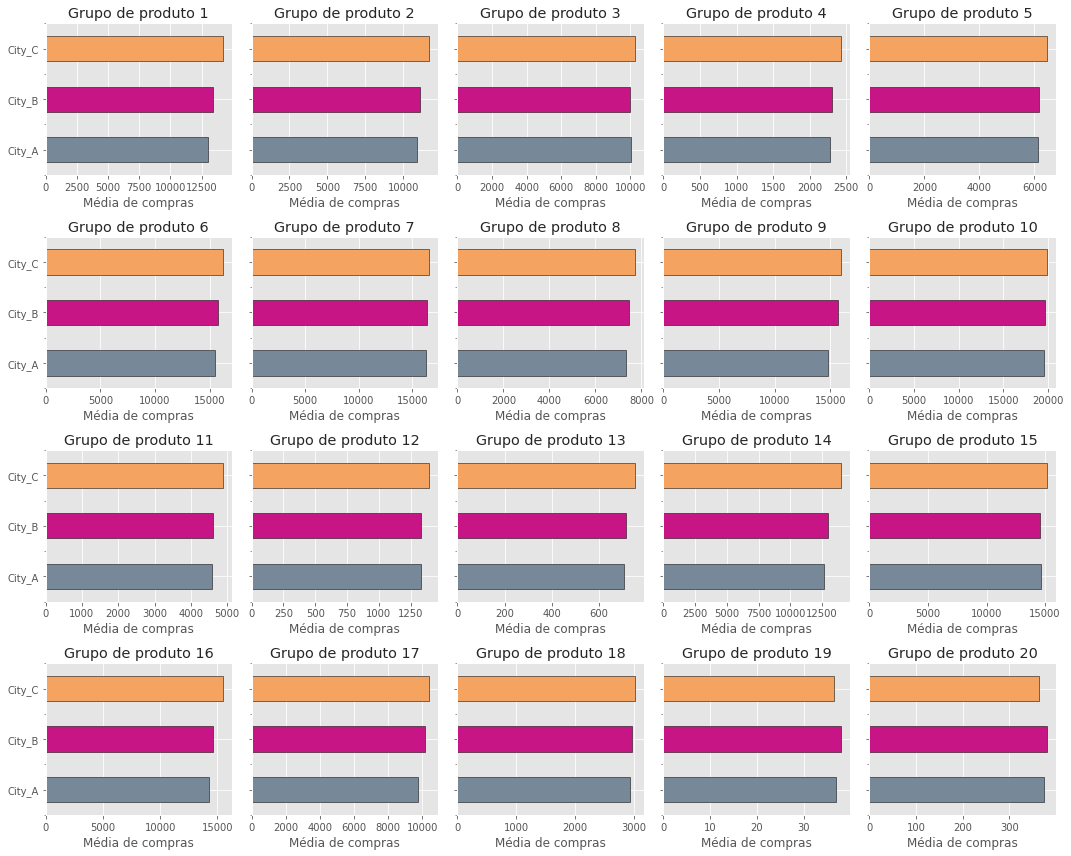

In [286]:
fig, ax = plt.subplots(nrows = 4 , ncols= 5, figsize = (15,12), sharey = True)

color = ['lightslategray','mediumvioletred','sandybrown']

product_category_1_list = sorted(list(df.Product_Category_1.unique()))

for subplot, product in zip(ax.flatten(),product_category_1_list ):
    individual_bar_plots(prod1_df,product,ax = subplot, title = 'Grupo de produto')
    
plt.tight_layout()

In [287]:
fig.savefig('Prod_City.png')

A primeira coisa que me chama a atenção é o produto 19 com sua média de compra bem inferior em relação aos outros produtos (menos de 40 dólares em média). Além disso, podemos notar que o produto 4 possui a maior média de compra, com a cidade C ocupando o primeiro lugar, seguida pela cidade B que possui uma ligeira vantagem sobre a cidade C.

##### **4.3 Média de compra da categoria 2 do produto por cidade**

In [288]:
City_A_Category_2 = df_city_A.groupby('Product_Category_2').mean()['Purchase']
City_B_Category_2 = df_city_B.groupby('Product_Category_2').mean()['Purchase']
City_C_Category_2 = df_city_C.groupby('Product_Category_2').mean()['Purchase']

In [289]:
prod2_df = pd.concat([City_A_Category_2,City_B_Category_2,City_C_Category_2], axis = 1)
prod2_df.columns =['City_A', 'City_B', 'City_C']

In [290]:
prod2_df

,City_A,City_B,City_C
Product_Category_2,,,
2.0,13053.860529,13451.023996,14215.305696
3.0,11057.043662,11138.206633,11476.698397
4.0,10076.695707,10104.359840,10475.700025
5.0,8657.538225,8752.697299,9728.257501
6.0,11230.700320,11241.891267,12084.406613
7.0,6853.707182,6770.263158,7086.039106
8.0,9804.542869,10178.217450,10807.470815
9.0,7220.100000,7209.586500,7421.354227
10.0,15231.085897,15638.343284,15968.774834


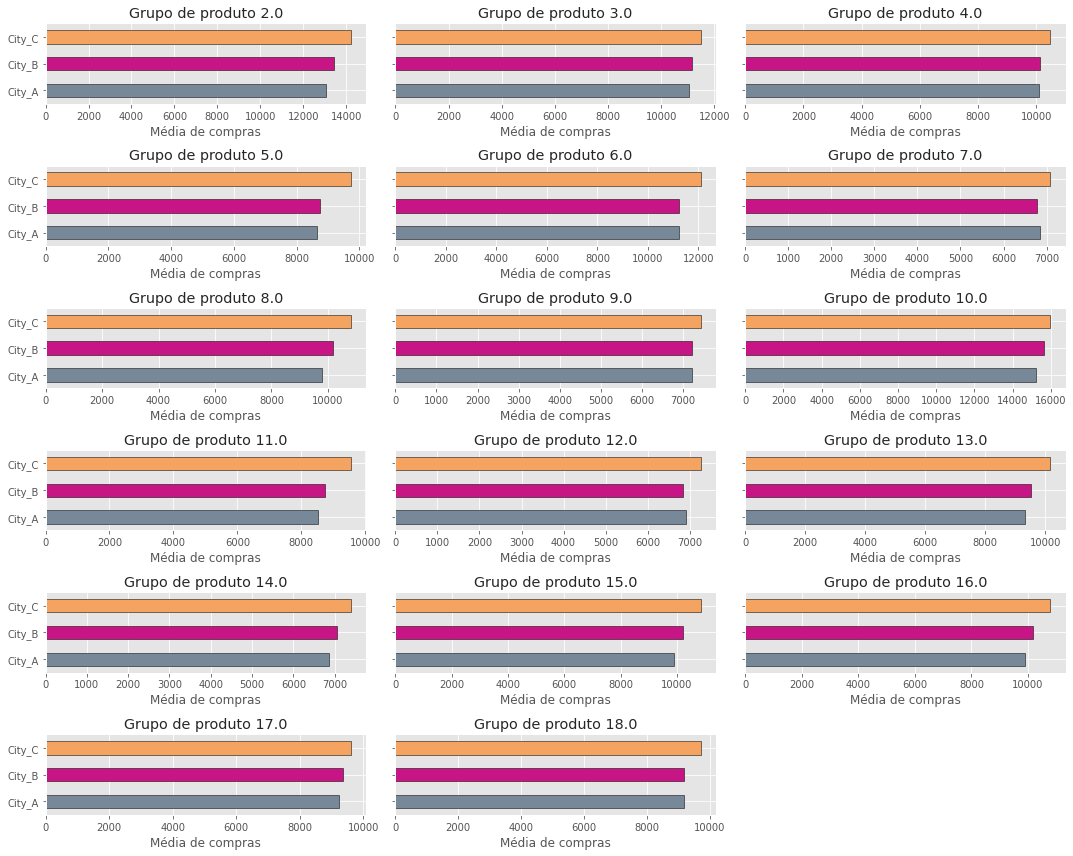

In [291]:
fig, ax = plt.subplots(nrows=6 , ncols=3, sharey = True, figsize = (15,12))

ax = trim_axs(ax, len(df.Product_Category_2.unique()[1:]) )

product_category_2_list = sorted(list(df.Product_Category_2.unique()[1:]))

for subplot, product in zip(ax.flatten(), product_category_2_list):
    individual_bar_plots(prod2_df,product,ax = subplot, title = 'Grupo de produto')

plt.tight_layout()

In [292]:
fig.savefig('Product_Category_2_by_City.png')

Conforme mencionado na descrição dos dados, o produto pode pertencer a outra categoria e podemos notar isso olhando para as parcelas acima. Temos um grupo de 17 produtos que também pertencem à primeira categoria e, como pode ser visto, o produto 10 é o de maior média de compra. Mais uma vez, a cidade C assume a primeira posição, seguida pela cidade B e A (semelhante à categoria de produto 1).

##### **4.4 Média de compra da categoria 3 do produto por cidade**

In [293]:
City_A_Category_3 = df_city_A.groupby('Product_Category_3').mean()['Purchase']
City_B_Category_3 = df_city_B.groupby('Product_Category_3').mean()['Purchase']
City_C_Category_3 = df_city_C.groupby('Product_Category_3').mean()['Purchase']

In [294]:
prod3_df = pd.concat([City_A_Category_3,City_B_Category_3,City_C_Category_3] , axis =1 )
prod3_df.columns = ['City_A', 'City_B', 'City_C']
prod3_df

,City_A,City_B,City_C
Product_Category_3,,,
3.0,13938.342105,13943.672862,13935.197917
4.0,9441.350105,9617.795995,10311.071786
5.0,11871.984287,12050.546659,12369.554136
6.0,12550.282780,13051.897374,13901.034439
8.0,12651.704656,12879.617802,13457.729853
9.0,9969.299221,10323.745929,10862.824780
10.0,13807.337264,13311.284058,13516.236928
11.0,11439.055066,12046.810881,12662.480138
12.0,8566.453079,8637.773274,8952.219504


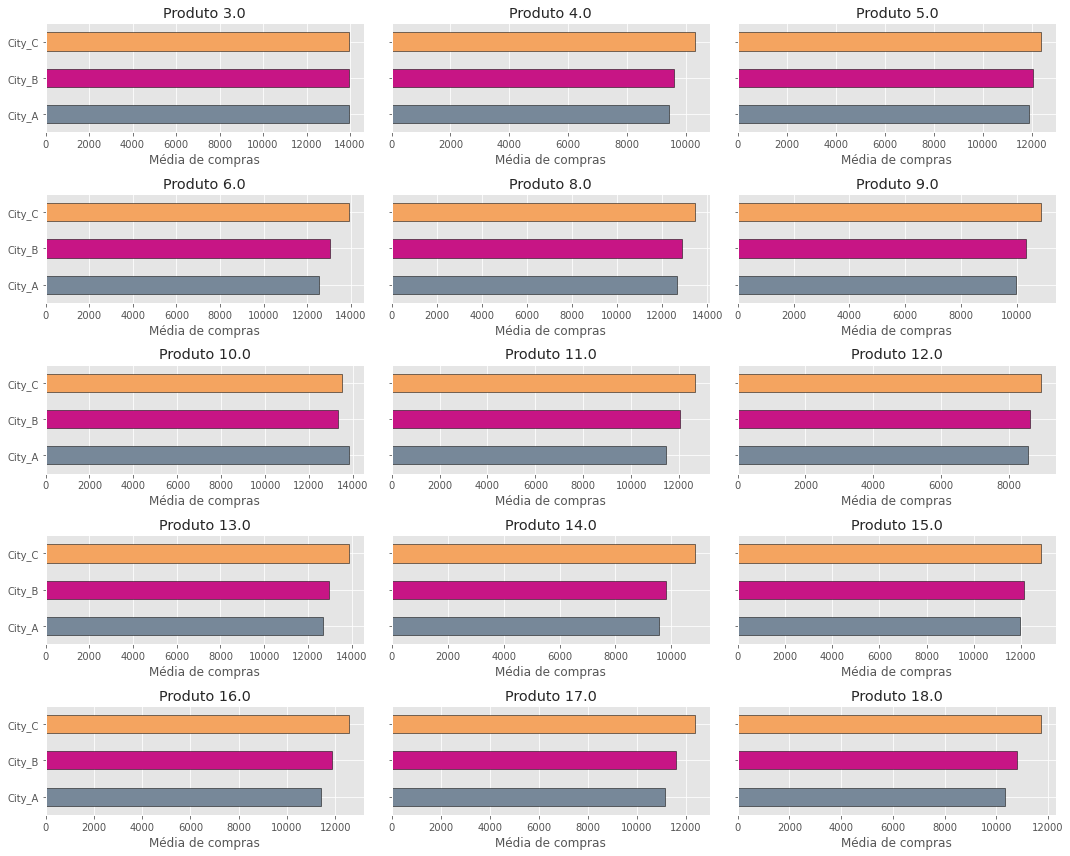

In [295]:
fig, ax  = plt.subplots( nrows= 5, ncols=3, sharey = True, figsize = (15,12))

product_category_3_list = sorted(list(df.Product_Category_3.unique()[1:]))

for subplot, product in zip(ax.flatten(), product_category_3_list):
    individual_bar_plots(prod3_df,product, ax = subplot, title = 'Produto')

plt.tight_layout()

Os gráficos acima mostram informações sobre a terceira categoria de produtos. Como pode ser visto, temos 15 produtos nesta categoria e o produto 3 é o maior meio de compra em todas as cidades.

In [296]:
fig.savefig('Product_Category_3_by_City.png')

---

#### **5. Análise de gênero**

Todos nós sabemos a relevância de entender o impacto do gênero na tomada de decisão de compra. Na verdade, muitos estudos têm levantado questões, por exemplo, sobre quem toma a decisão de compra nas famílias. Além disso, também parece importante inspecionar as diferenças de gênero nos estilos e padrões de tomada de decisão de compra no que diz respeito a categorias de produtos, preço e outras características.

Dito isso, vamos trabalhar em nossa análise de dados e obter alguns insights simples, mas relevantes, sobre o comportamento dos clientes. Primeiro, traçaremos o total de compras e a compra média de cada gênero. Em seguida, traçaremos a média de compra por faixa etária e, por fim, veremos como homens e mulheres se diferenciam em termos de aquisição de produtos nas cidades A, B e C.

##### **5.1 Número de compras e média de compras por gênero**

Agora, olhando os gráficos abaixo, podemos ver que o total de consumidores do sexo masculino (**414259**) é três vezes maior do que o número de mulheres (**135809**). Também podemos perceber que, surpreendentemente, não há grande diferença no que diz respeito à média de compra para ambos os sexos. 

Apesar da evidente disparidade de quantidade de homens e mulheres, a média de compra dos consumidores masculinos apresenta apenas uma ligeira vantagem sobre a compra média feminina. Com base nisso, diria que as consumidoras são muito significativas para o negócio e, por exemplo, podem ser alvo de campanhas de marketing especiais.

In [297]:
df.Gender.value_counts()

M    414259
F    135809
Name: Gender, dtype: int64

In [298]:
df.groupby('Gender').mean()['Purchase'].sort_values(ascending = False)

Gender
M    9437.526040
F    8734.565765
Name: Purchase, dtype: float64

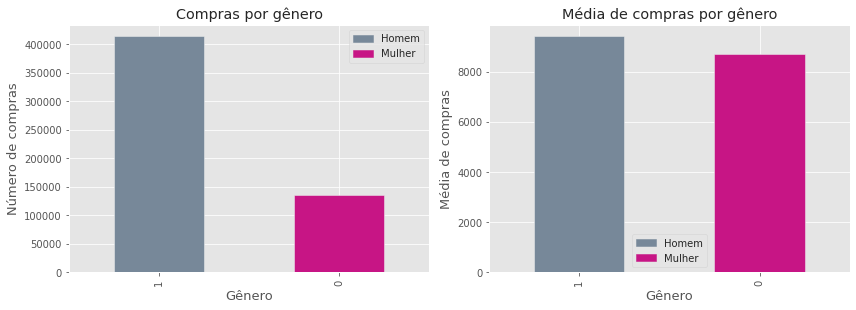

In [328]:
plt.subplot(221)

df.Gender.value_counts().plot(kind= 'bar', title = 'Compras por gênero', color = color)

plt.xlabel('Gênero', fontsize = 13)
plt.ylabel('Número de compras', fontsize = 13)
import matplotlib.patches as mpatches
gray_patch = mpatches.Patch(color ='lightslategray', label = 'Homem')
violet_patch = mpatches.Patch(color = 'mediumvioletred', label = 'Mulher')
plt.legend(handles = [gray_patch,violet_patch], loc = 'best')

plt.subplot(222)

df.groupby('Gender').mean()['Purchase'] .sort_values(ascending = False).plot(kind = 'bar',
                                                                         color = color,
                                                                         title = 'Média de compras por gênero')
                                                                    
plt.ylabel('Média de compras', fontsize = 13)
plt.xlabel('Gênero', fontsize = 13)
plt.legend(handles = [gray_patch,violet_patch], loc = 'best')
plt.tight_layout()


plt.rcParams['figure.figsize'] =(12,8)

---

##### **5.2 Média de compras por gênero e faixa etária**

Com o objetivo de comparar o padrão de compra das diferentes faixas etárias e sexos, podemos observar os gráficos de barras a seguir. Eles mostram que a média de compra do grupo dos homens é mais de 1000 USD maior do que a média de compra do grupo das mulheres para clientes de 18 a 25 anos. Também podemos ver que os consumidores do sexo masculino ocupam o primeiro lugar em todas as faixas etárias, embora a diferença não é tão perceptível como na faixa etária de 18 a 25 anos.


In [300]:
gender_age_pvt = df.pivot_table(df , index = ['Age', 'Gender'], aggfunc = 'mean')['Purchase']
gender_age_pvt

Age    Gender
0-17   F         8338.771985
       M         9235.173670
18-25  F         8343.180201
       M         9440.942971
26-35  F         8728.251754
       M         9410.337578
36-45  F         8959.844056
       M         9453.193643
46-50  F         8842.098947
       M         9357.471509
51-55  F         9042.449666
       M         9705.094802
55+    F         9007.036199
       M         9438.195603
Name: Purchase, dtype: float64

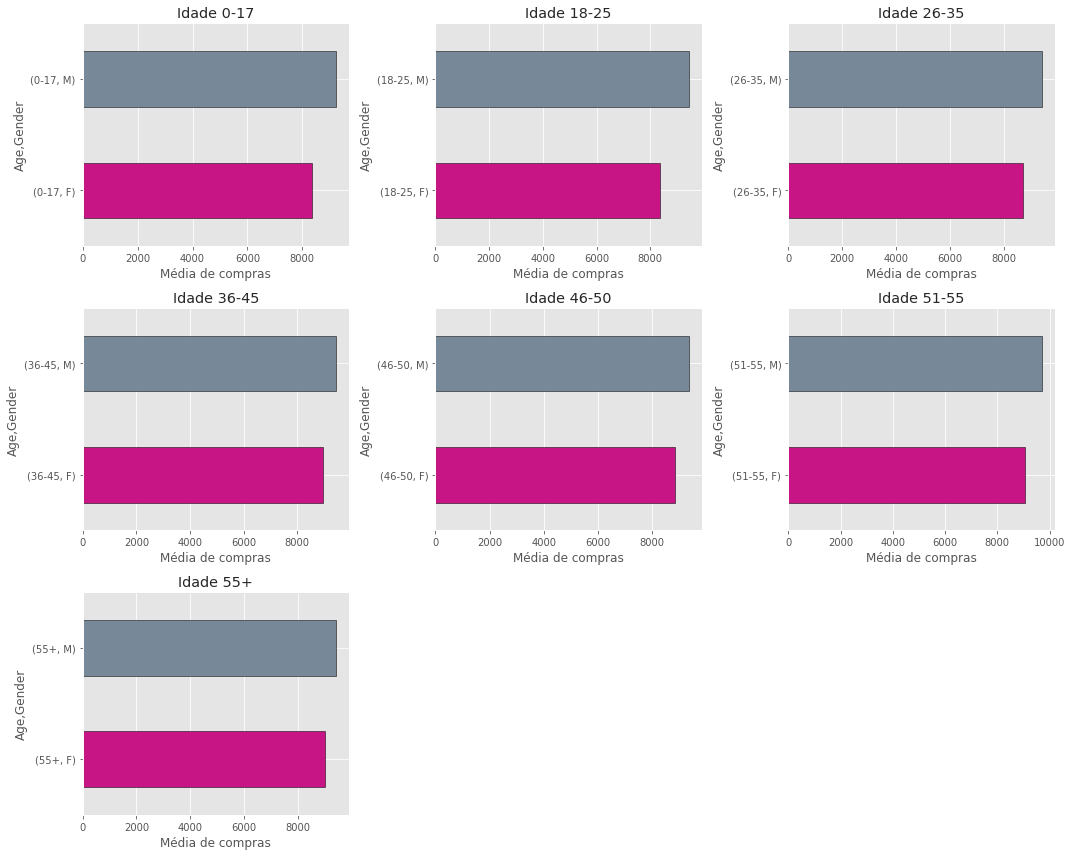

In [301]:
fig, ax = plt.subplots(nrows = 3 , ncols= 3, figsize = (15,12), sharey = False)

ax = trim_axs(ax, len(df.Age.unique()))

color = ['mediumvioletred','lightslategray']

for subplot, Age in zip(ax.flatten(),age_list ):
    individual_bar_plots(gender_age_pvt,Age,ax = subplot, title = 'Idade')
    
plt.tight_layout()

In [302]:
fig.savefig('Age_Gender.png')

---

##### **5.3 Média de compras por gênero e cidade**

A última análise de gênero consiste em compreender como foram feitas as compras para ambos os sexos em cada cidade. Para isso, vamos analisar os gráficos de barras abaixo que mostram exatamente o que procuramos. Eles mostram que os homens gastam mais dinheiro do que as mulheres em todas as cidades e que a cidade C ocupa a primeira posição em termos de meios de compra para ambos os sexos. 

É importante notar também que os homens da cidade B compraram mais do que os da cidade A, enquanto as mulheres da cidade A adquiriram mais do que as que moram na cidade B.

In [303]:
purchase_mean_by_gender_city = df.loc[:,['Gender', 'City_Category','Purchase']]

pvt_purchase_mean_by_gender_city = purchase_mean_by_gender_city.pivot_table(purchase_mean_by_gender_city, 
                                                                           index = ['Gender','City_Category'],
                                                                           aggfunc = 'mean')

In [304]:
pvt_purchase_mean_by_gender_city

Purchase
Gender City_Category             
F      A              8579.708576
       B              8540.677694
       C              9130.107518
M      A              9017.834470
       B              9354.854433
       C              9913.567248

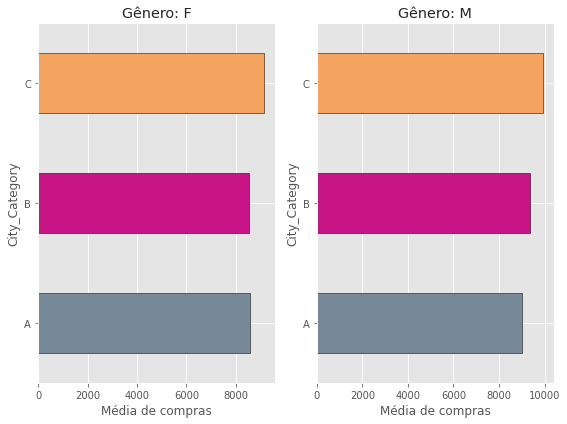

In [305]:
fig, ax = plt.subplots(nrows = 1 , ncols= 2, figsize = (8,6), sharey = False)

color = ('lightslategray','mediumvioletred','sandybrown')

gender_list = ['F','M']

for subplot, gender in zip(ax.flatten(),gender_list ):
    individual_bar_plots(pvt_purchase_mean_by_gender_city, gender, ax = subplot, title = 'Gênero:')
    
plt.tight_layout()

---

#### **6. Análise de emprego**

##### **6.1 Média de compras por emprego**

Este gráfico de barras nos dá informações generalizadas sobre os hábitos de compra de cada consumidor em relação ao seu emprego. Por exemplo, podemos notar que os empregos 12, 15 e 17 ocupam as três primeiras posições em termos de meios de compra. Também podemos ver que as ocupações 9, 19 e 20 gastam menos dinheiro do que outras. Essas informações são realmente úteis? Podemos obter informações sobre a quantidade de dinheiro que cada profissional gasta por cidade? Bem, isso é exatamente o que vemos na visualização subsequente.

Embora o primeiro gráfico de barras nos forneça informações importantes, o segundo dado permite-nos ter uma melhor compreensão do dinheiro gasto por cada ocupação nas cidades A, B e C.






Text(0, 0.5, 'Média de compras')

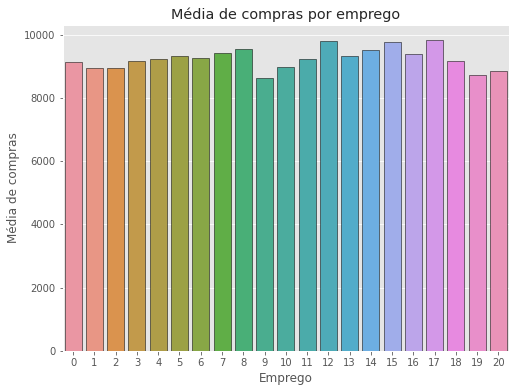

In [306]:
plt.figure(figsize=(8, 6))

sns.barplot(x = df.groupby('Occupation').mean()['Purchase'].index ,
           y = df.groupby('Occupation').mean()['Purchase'].values,
            orient = 'v',
            edgecolor = 'black')
plt.title('Média de compras por emprego')
plt.xlabel('Emprego')
plt.ylabel('Média de compras')

##### **6.2 Emprego por cidade**

Os gráficos de barras abaixo representam a média de compra de cada emprego em cada cidade. É interessante que a cidade C tenha os maiores meios de compra em quase todos os empregos. Observamos uma mudança nesse padrão apenas com as ocupações 8, 9 e 19. Outro fato interessante é que temos a maior quantidade de dinheiro (geral) gasto na cidade A pelas pessoas cujo emprego é o número 8.

Portanto, a questão é que, se separarmos cada ocupação em gráficos diferentes, é mais provável que possamos aproveitar os insights com facilidade. Em outras palavras, isso torna especialmente fácil para colegas de outras equipes (por exemplo, departamento de marketing) usar nossas descobertas. Podemos simplesmente exportá-los para uma pasta de plotagens, e as pessoas podem navegar pelas imagens e arrastá-las e soltá-las em uma apresentação do PowerPoint ou outro relatório.

In [307]:
df.rename(columns= {"City_Category" : "City_Cat", "Occupation": "Occup"}, inplace= True)
df.head(3)

,User_ID,Product_ID,Gender,Age,Occup,City_Cat,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422


In [308]:
occ_list = sorted(df.Occup.unique())

occupation_purchase_city = df.pivot_table(df, index = ['Occup','City_Cat'])['Purchase']

In [309]:
color = ['lightslategray','mediumvioletred','sandybrown']

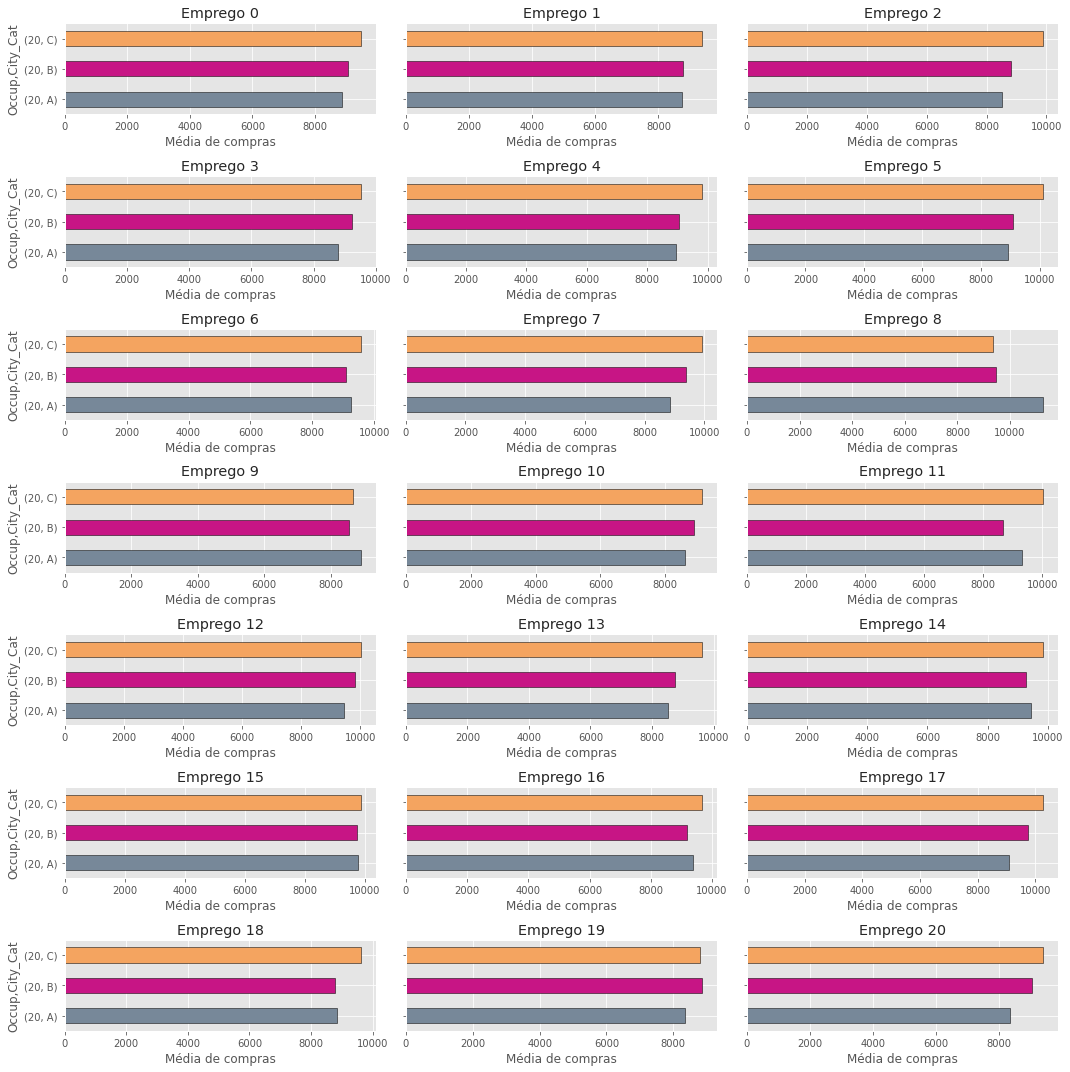

In [310]:
fig, ax = plt.subplots(nrows=7 , ncols=3, figsize = (15,15), sharey = True)

for subplot, occupation in zip(ax.flatten(), occ_list):
    individual_bar_plots(occupation_purchase_city,occupation, ax = subplot , title = 'Emprego')
       
plt.tight_layout()

In [311]:
fig.savefig("Occupation_cityCat.png")

#### **7. Análise de estado civil**


In [312]:
df.head()

,User_ID,Product_ID,Gender,Age,Occup,City_Cat,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [313]:
df.Marital_Status.value_counts()

0    324731
1    225337
Name: Marital_Status, dtype: int64

Text(0.5, 0, 'Compras')

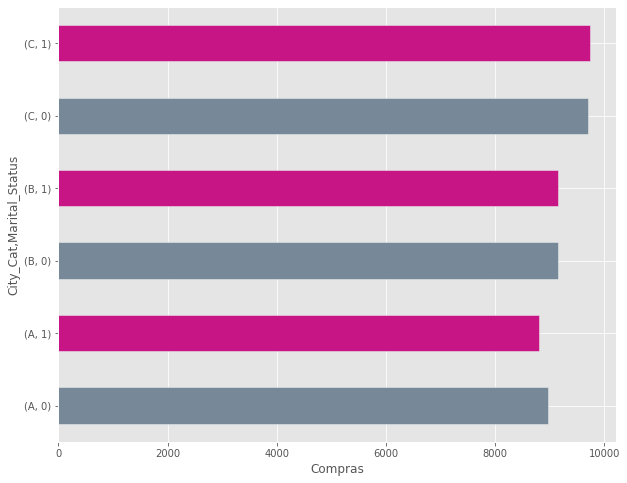

In [314]:
marital_status_city = df.pivot_table(df, index = ['City_Cat', 'Marital_Status'], aggfunc = 'mean')['Purchase']
marital_status_city.plot(kind = 'barh', color = color[0:-1], figsize = (10,8))
plt.xlabel('Compras')

#### **8. HeatMap**

Basicamente, o mapa de calor é uma representação gráfica de dados que usa um esquema de codificação por cores para representar diferentes valores. Neste caso, estamos gerando um mapa de calor de correlações entre recursos de nosso dataset.

Para gerar um mapa de calor, é preciso codificar numericamente os dados categóricos. Em outras palavras, temos que converter as colunas Product_ID, Gender, Age, City_Cat e Stay_In_Current_City_Years em colunas numéricas.

Após a codificação, ficamos com o gráfico abaixo. É interessante notar que existe uma correlação positiva entre os produtos, que é exatamente o que poderíamos esperar, já que eles podem pertencer a categorias diferentes. Além disso, a correlação entre idade e estado civil outro ponto interessante a ser mencionado.

In [315]:
df.Product_ID

0         P00069042
1         P00248942
2         P00087842
3         P00085442
4         P00285442
            ...    
550063    P00372445
550064    P00375436
550065    P00375436
550066    P00375436
550067    P00371644
Name: Product_ID, Length: 550068, dtype: object

In [316]:
def age_encoder(age_group):
    
    if age_group == '0-17':
        x = 1
        
    elif age_group == '18-25':
        x = 2
    
    elif age_group == '26-35':
        x = 3
        
    elif age_group == '36-45':
        x = 4 
        
    elif age_group == '46-50':
        x = 5
        
    elif age_group == '51-55':
        x = 6
        
    elif age_group == '55+':
        x = 7
        
    return x

In [317]:
df.head()

,User_ID,Product_ID,Gender,Age,Occup,City_Cat,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [318]:
df.Gender = df.Gender.map({'F': 0 , 'M': 1 })
df.City_Cat = df.City_Cat.map({ 'A':10, 'B':20, 'C':30})
df.Product_ID = df.Product_ID.str.replace("P","").astype(int)
df.Stay_In_Current_City_Years = df.Stay_In_Current_City_Years.map({'0':int(0),'1':int(1),'2': int(2),'3':int(3), '4+': int(4)})

df.head()

,User_ID,Product_ID,Gender,Age,Occup,City_Cat,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,69042,0,0-17,10,10,2,0,3,NaN,NaN,8370
1,1000001,248942,0,0-17,10,10,2,0,1,6.0,14.0,15200
2,1000001,87842,0,0-17,10,10,2,0,12,NaN,NaN,1422
3,1000001,85442,0,0-17,10,10,2,0,12,14.0,NaN,1057
4,1000002,285442,1,55+,16,30,4,0,8,NaN,NaN,7969


In [319]:
df.Age = df.Age.apply(age_encoder)

In [320]:
df.head()

,User_ID,Product_ID,Gender,Age,Occup,City_Cat,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,69042,0,1,10,10,2,0,3,NaN,NaN,8370
1,1000001,248942,0,1,10,10,2,0,1,6.0,14.0,15200
2,1000001,87842,0,1,10,10,2,0,12,NaN,NaN,1422
3,1000001,85442,0,1,10,10,2,0,12,14.0,NaN,1057
4,1000002,285442,1,7,16,30,4,0,8,NaN,NaN,7969


In [321]:
df.columns = [ 'User_ID','Prod_ID','Gender','Age','Occupation', 'City', 'Years_In_Citys', 'Marital_St', 
       'Prod_Cat1', 'Prod_Cat2', 'Prod_Cat3','Purchase'
        ]

In [322]:
df.head()

,User_ID,Prod_ID,Gender,Age,Occupation,City,Years_In_Citys,Marital_St,Prod_Cat1,Prod_Cat2,Prod_Cat3,Purchase
0,1000001,69042,0,1,10,10,2,0,3,NaN,NaN,8370
1,1000001,248942,0,1,10,10,2,0,1,6.0,14.0,15200
2,1000001,87842,0,1,10,10,2,0,12,NaN,NaN,1422
3,1000001,85442,0,1,10,10,2,0,12,14.0,NaN,1057
4,1000002,285442,1,7,16,30,4,0,8,NaN,NaN,7969


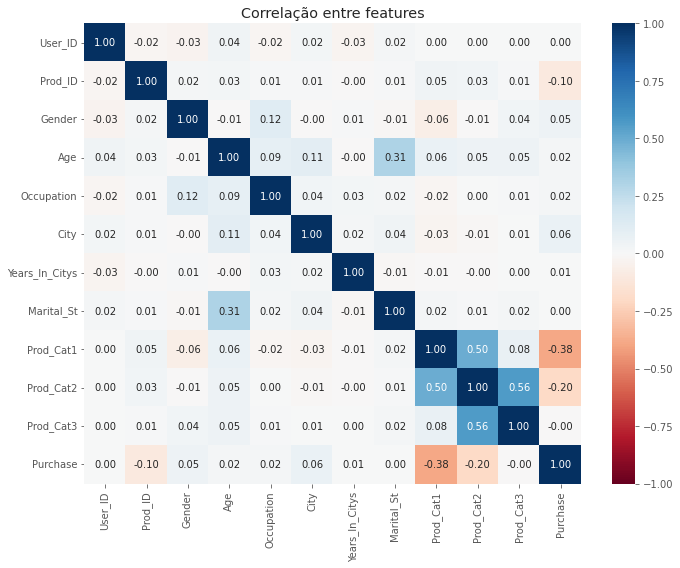

In [323]:
corr_matrix = df.corr(method='spearman')

fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(corr_matrix, cmap='RdBu', annot=True, fmt='.2f',
           vmin=-1, vmax=1)

plt.title("Correlação entre features")

plt.tight_layout()
plt.show()

In [324]:
fig.savefig('Cor_matrix.png')

#### **9. ClusterMap**

Terminaremos esta análise traçando um mapa de cluster. Os mapas de cluster usam clustering hierárquico para agrupar recursos de acordo com o grau de relação entre eles. Isso torna as correlações entre as variáveis ​​especialmente informativas quando estamos analisando as relações entre elas.

Em nosso caso, temos 11 características que queremos investigar, então, em vez de examinar o heatmat para a qual a variável está associada positiva ou negativa, o gráfico será segmentado em clusters, o que é mais fácil de analisar.

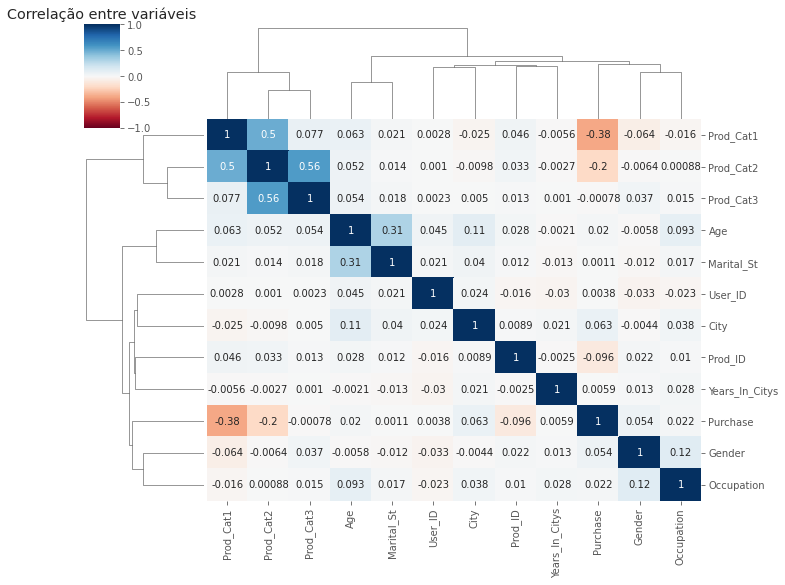

In [325]:
clustermap = sns.clustermap(corr_matrix, method='ward', cmap='RdBu', annot=True,
               vmin=-1, vmax=1, figsize=(10,8))

plt.title("Correlação entre variáveis")
plt.show()

In [326]:
clustermap.savefig('Clustermap.png')

Olhando para o gráfico acima, podemos ver que o algoritmo de agrupamento acredita que product_category 2 e 3 se agrupam, enquanto a idade e o estado civil formam outro agrupamento fortemente associado. Podemos ver isso olhando para a ligação entre eles. São formados primeiro e têm o ramo mais curto, o que indica que são mais semelhantes aos que têm o ramo mais alto.